In [14]:
import pandas as pd
import numpy as np
import os

import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score



In [2]:
telegram = pd.read_csv('../datasets/10_por_cento_mais_virais_telegram_com_classes_por_corte.csv')

In [4]:
telegram.head()

,texto_original,frequencia,texto_limpo,text_processed,idioma,classe
0,Justamente.\nhttps://t.me/canalselvabrasilofic...,895,justamente selva brasil oficial,justamente t selva brasil oficial,pt,4
1,"▪️ A queda da monarquia também.\n\n""E conhecer...",790,a queda da monarquia tambem e conhecereis a ve...,queda monarquia tambem conhecereis verdade ver...,pt,4
2,Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...,358,bem vindoa ao grupo ipira noticias compartilhe...,bem vindoa grupo ipira noticias compartilhe li...,pt,4
3,INVISTA CONOSCO E RECEBA✅\n A SEU LUCRO ESTÁ...,335,invista conosco e receba a seu lucro esta segu...,invista conosco receba lucro segurada retorno ...,pt,4
4,"Meu povo, ânimo! A vida segue!\n\n\n\nPara que...",240,meu povo animo a vida segue para quem gosta de...,povo animo vida segue gosta medicina natural d...,pt,3


In [3]:
# Contar a quantidade de valores nulos na coluna 'texto_original'
nulos_count = telegram['texto_original'].isnull().sum()

# Exibir o resultado
print(f"Quantidade de valores nulos na coluna 'texto_original': {nulos_count}")


Quantidade de valores nulos na coluna 'texto_original': 0


In [3]:
dfsp = telegram.copy()

In [7]:
dfsp['classe'].value_counts()


classe
0    9560
1    3716
2    3233
3       7
4       4
Name: count, dtype: int64

In [4]:
dfsp = dfsp.replace({3:2, 4:2})
dfsp['classe'].value_counts()

classe
0    9560
1    3716
2    3244
Name: count, dtype: int64

In [10]:
dfsp.shape

(16520, 6)

# Sem pré-processamento

In [5]:
# Criando transformador personalizado para o word2vec

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1, workers=4):
        self.size = size # o tamanho do vetor de palavras (dimensionalidade do embedding).
        self.window = window # o tamanho da janela para o contexto da palavra.
        self.min_count = min_count # o número mínimo de ocorrências de uma palavra para ser considerada.
        self.workers = workers #  número de threads usadas para treinar o modelo.

    def fit(self, X, y=None):
        self.w2v_model = Word2Vec(sentences=[text.split() for text in X], vector_size=self.size,
                                  window=self.window, min_count=self.min_count, workers=self.workers)
        return self

    def transform(self, X):
        return np.array([np.mean([self.w2v_model.wv[word] for word in text.split() if word in self.w2v_model.wv]
                                 or [np.zeros(self.size)], axis=0) for text in X])


In [6]:
# Definir os vetorizadores e modelos
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1)),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2)),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3)),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1)),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2)),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3)),
    'Word2Vec': Word2VecTransformer()
}


In [7]:

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import defaultdict


def evaluate_model_with_outer_cv(X_train_val, y_train_val, X_test, y_test, vectorizer, vec_name, model, scaler,
                                 outer_splits=5, oversampler='random'):

    oversampler_dict = {
        'random': RandomOverSampler(random_state=42),
        'smote': SMOTE(random_state=42),
        'adasyn': ADASYN(random_state=42)
    }

    if oversampler not in oversampler_dict:
        raise ValueError("Opção de oversampler inválida. Escolha entre: 'random', 'smote', 'adasyn'")

    sampler = oversampler_dict[oversampler]

    outer_cv = RepeatedStratifiedKFold(n_splits=outer_splits, n_repeats=3, random_state=42)
    all_fold_results = []

    unique_classes = np.unique(y_train_val)
    total_amostras_por_classe = defaultdict(int)

    for train_idx, val_idx in outer_cv.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        y_train = y_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_val = y_train_val.iloc[val_idx]

        # Sanear os dados de entrada
        X_train = X_train.fillna("")
        X_val = X_val.fillna("")
        X_test = X_test.fillna("")

        # Vetorização antes do oversampling
        X_train_vec = vectorizer.fit_transform(X_train)
        X_val_vec = vectorizer.transform(X_val)
        X_test_vec = vectorizer.transform(X_test)

        # Escalonamento (se aplicável)
        if scaler:
            X_train_vec = scaler.fit_transform(X_train_vec)
            X_val_vec = scaler.transform(X_val_vec)
            X_test_vec = scaler.transform(X_test_vec)

        # Aplicar oversampling
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_vec, y_train)

        # Atualizar total por classe
        y_train_resampled_counts = pd.Series(y_train_resampled).value_counts()
        for cls, count in y_train_resampled_counts.items():
            total_amostras_por_classe[str(cls)] = count

        # Treinamento e predição
        model.fit(X_train_resampled, y_train_resampled)
        y_val_pred = model.predict(X_val_vec)
        y_test_pred = model.predict(X_test_vec)

        val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        test_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

        val_accuracy = accuracy_score(y_val, y_val_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        val_f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        val_f1_micro = f1_score(y_val, y_val_pred, average='micro', zero_division=0)
        test_f1_micro = f1_score(y_test, y_test_pred, average='micro', zero_division=0)
        val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
        test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        if hasattr(model, "predict_proba"):
            y_val_proba = model.predict_proba(X_val_vec)
            y_test_proba = model.predict_proba(X_test_vec)

            if len(unique_classes) > 2:
                y_val_bin = label_binarize(y_val, classes=unique_classes)
                y_test_bin = label_binarize(y_test, classes=unique_classes)
                val_auc = roc_auc_score(y_val_bin, y_val_proba, average='macro', multi_class='ovr')
                test_auc = roc_auc_score(y_test_bin, y_test_proba, average='macro', multi_class='ovr')
            else:
                val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
        else:
            val_auc = test_auc = None

        for label in unique_classes:
            label_str = str(label)
            val_metrics = val_report.get(label_str, {'precision': 0, 'recall': 0, 'f1-score': 0})
            test_metrics = test_report.get(label_str, {'precision': 0, 'recall': 0, 'f1-score': 0})

            all_fold_results.append({
                'class': label_str,
                'val_f1_macro': val_f1_macro,
                'test_f1_macro': test_f1_macro,
                'val_f1_micro': val_f1_micro,
                'test_f1_micro': test_f1_micro,
                'val_f1_weighted': val_f1_weighted,
                'test_f1_weighted': test_f1_weighted,
                'val_precision': val_metrics['precision'],
                'test_precision': test_metrics['precision'],
                'val_recall': val_metrics['recall'],
                'test_recall': test_metrics['recall'],
                'val_f1_score': val_metrics['f1-score'],
                'test_f1_score': test_metrics['f1-score'],
                'val_accuracy': val_accuracy,
                'test_accuracy': test_accuracy,
                'val_auc_roc': val_auc,
                'test_auc_roc': test_auc,
                'Vectorizer': vec_name,
                'Model': model.__class__.__name__,
                'Scaler': scaler.__class__.__name__ if scaler else 'None'
            })

    print("\nResumo final do número de amostras por classe (após oversampling em cada fold):")
    for cls, total in total_amostras_por_classe.items():
        print(f"- Classe {cls}: {total} amostras")

    return pd.DataFrame(all_fold_results), y_test, y_test_pred


## Regressão Logística

In [12]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
models = {
    'Logistic Regression': OneVsRestClassifier(
        LogisticRegression(
          solver='saga'))

}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [18]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'smote' ou 'adasyn'
            )

            # Concatena os resultados
            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_regressao_logistica_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_regressao_logistica.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

### Matriz de confusão

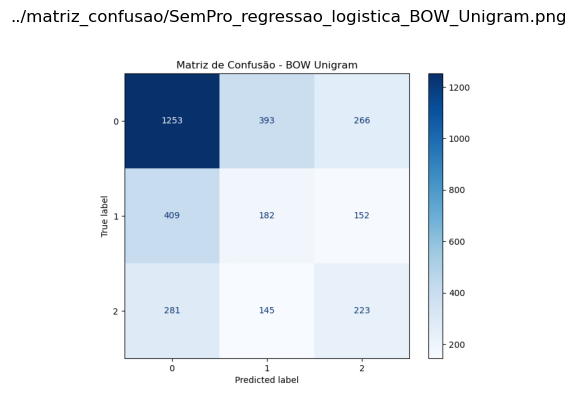

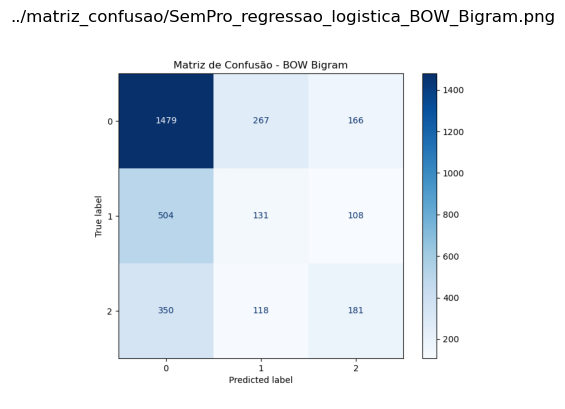

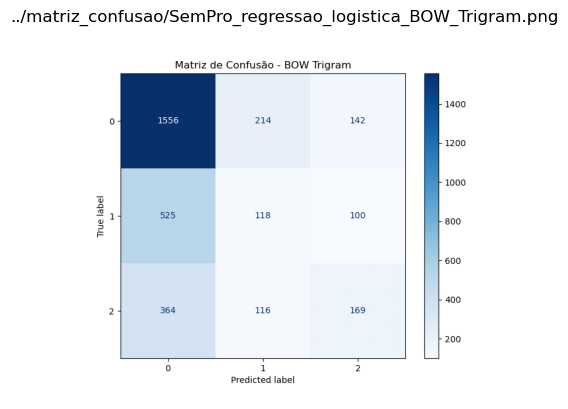

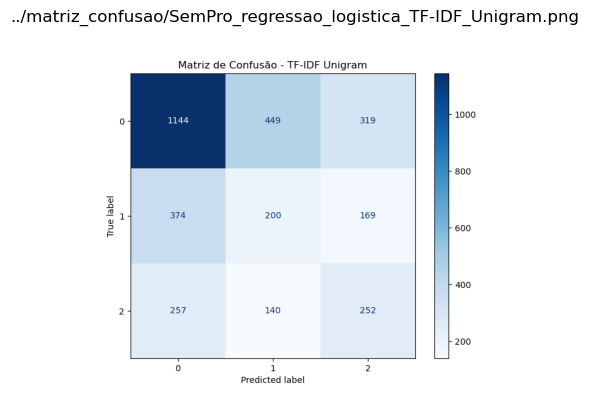

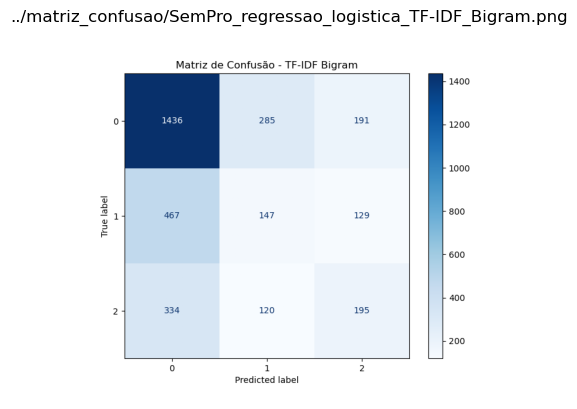

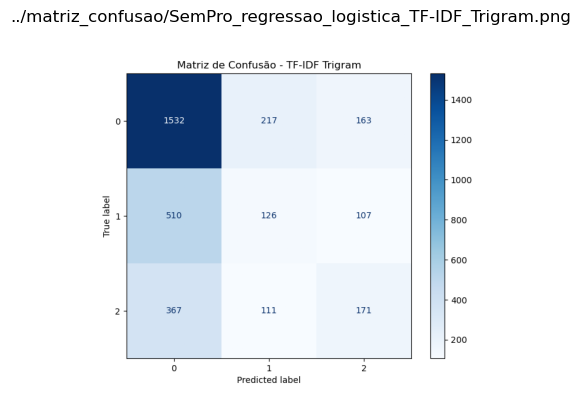

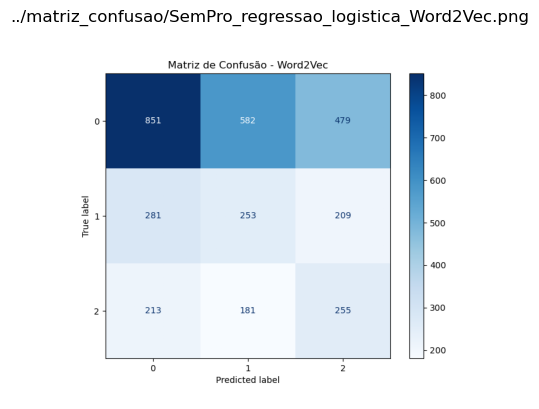

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_regressao_logistica_BOW_Unigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_BOW_Bigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_BOW_Trigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Regressão Logística com Regularização

In [20]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
models = {
    'Logistic Regression l1' : OneVsRestClassifier(LogisticRegression(penalty='l1', solver='saga', C=1.0))
    
}

scalers = {
    'MaxAbsScaler': MaxAbsScaler()
}

In [22]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'smote' ou 'adasyn'
            )

            # Concatena os resultados
            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_regressao_logistica_Lasso_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_regressao_logistica_Lasso.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

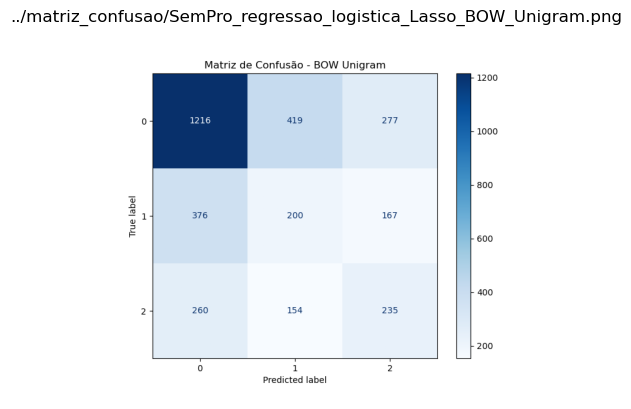

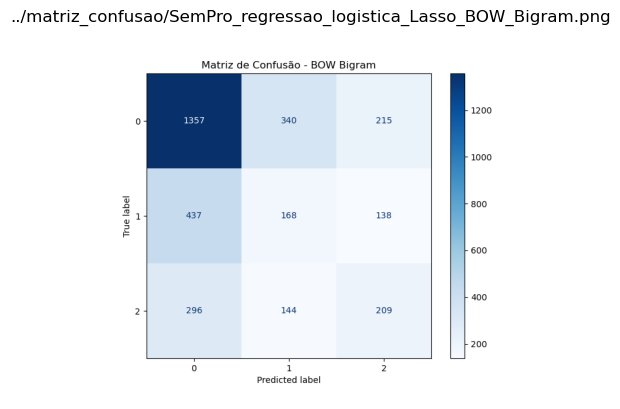

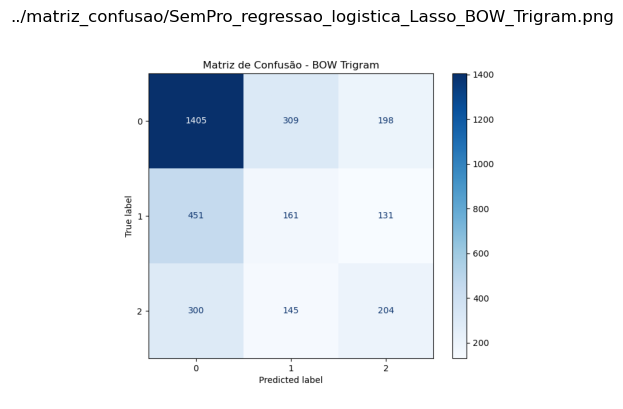

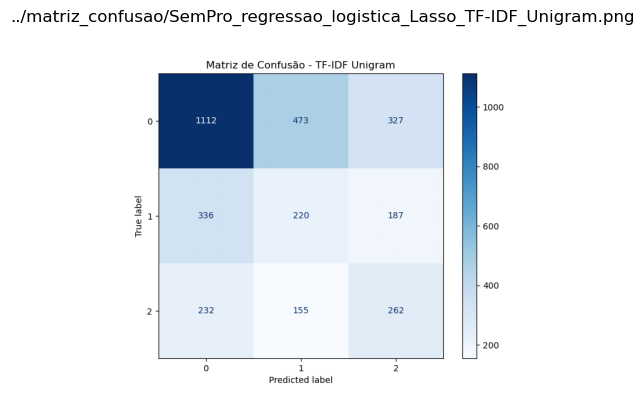

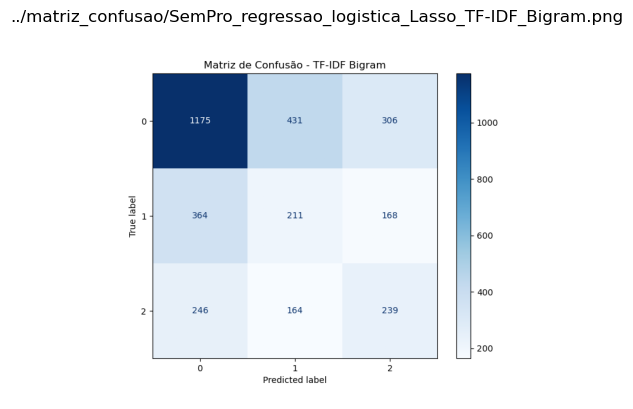

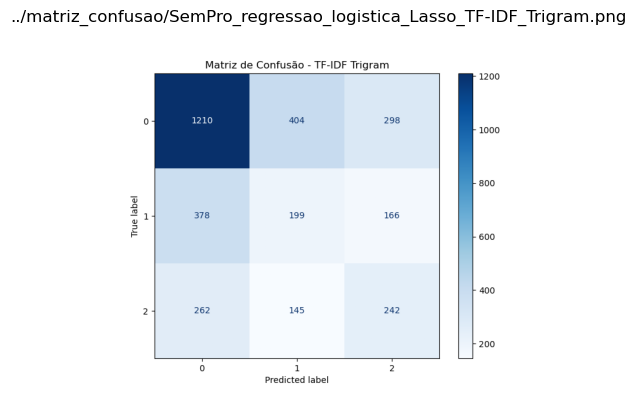

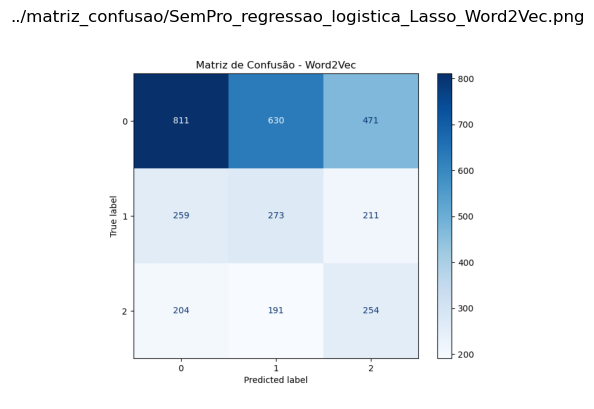

In [23]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_BOW_Unigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_BOW_Bigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_BOW_Trigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_regressao_logistica_Lasso_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Árvore de decisão

In [24]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:

models = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(
    criterion='entropy',             # 'entropy' para medir a impureza dos nós, 'gini' é uma alternativa
    max_depth=30,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=30,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=30,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001    # Redução mínima de impureza necessária para realizar uma divisão

))
}

scalers = {
    'None': None
}

In [26]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'smote'
            )

            # Concatena os resultados
            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_arvore_decisao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_arvore_decisao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

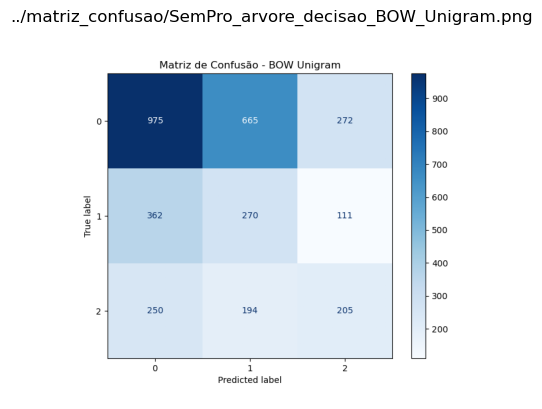

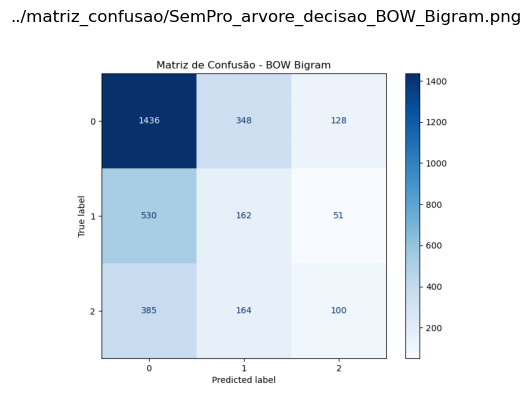

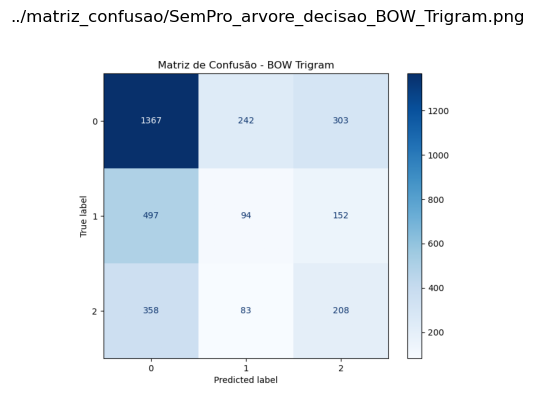

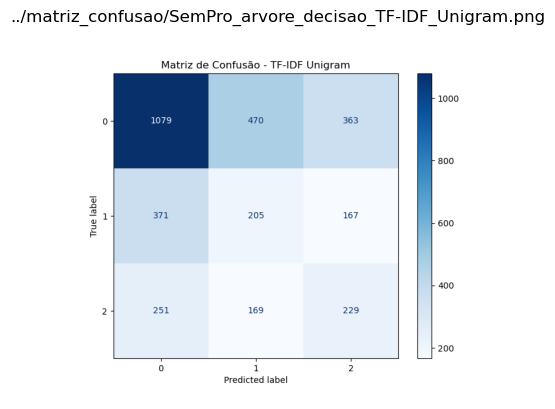

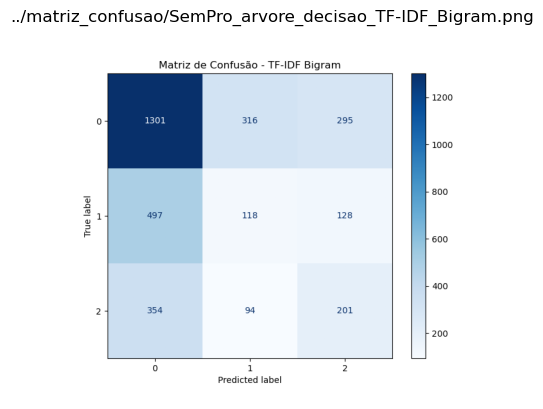

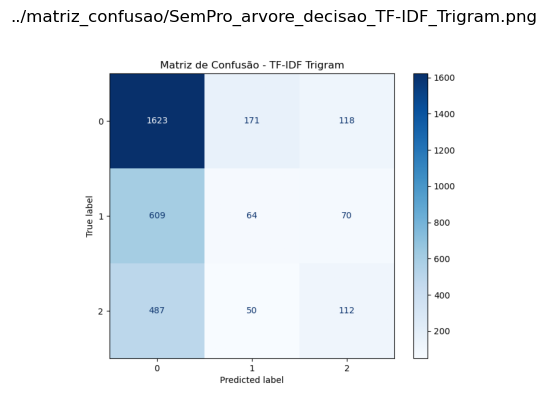

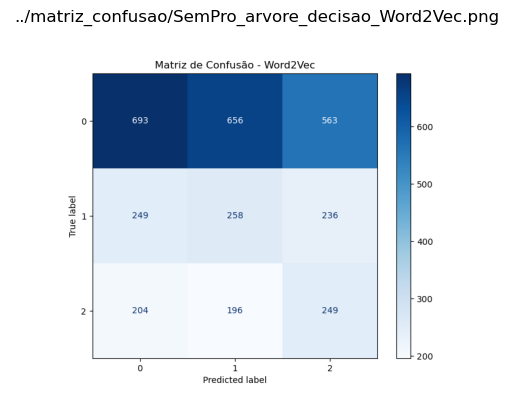

In [27]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_arvore_decisao_BOW_Unigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_BOW_Bigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_BOW_Trigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Árvore de decisão com regularização

In [28]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:

models = {
    'Decision Tree ccp_alpha': OneVsRestClassifier(DecisionTreeClassifier(
    criterion='entropy',             # 'gini' para medir a impureza dos nós, 'entropy' é uma alternativa
    max_depth=30,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=30,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=30,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001,    # Redução mínima de impureza necessária para realizar uma divisão
    ccp_alpha=0.01                   # Termo para regularização pois controla a poda de custo-complexidade (valores maiores simplificam a árvore).

))
}

scalers = {
    'None': None
}

In [30]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'smote'
            )

            # Concatena os resultados
            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_arvore_decisao_com_regularizacao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

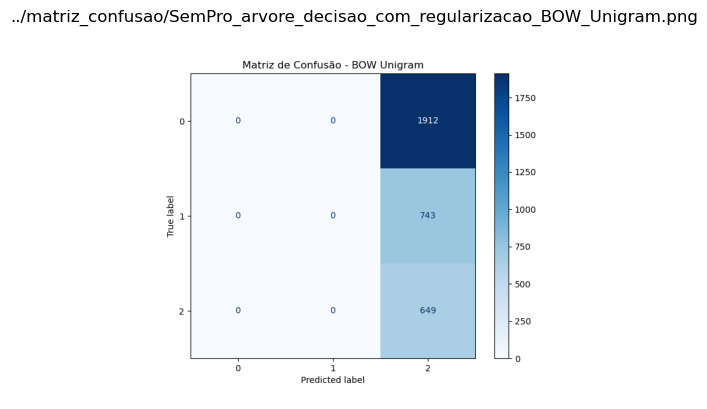

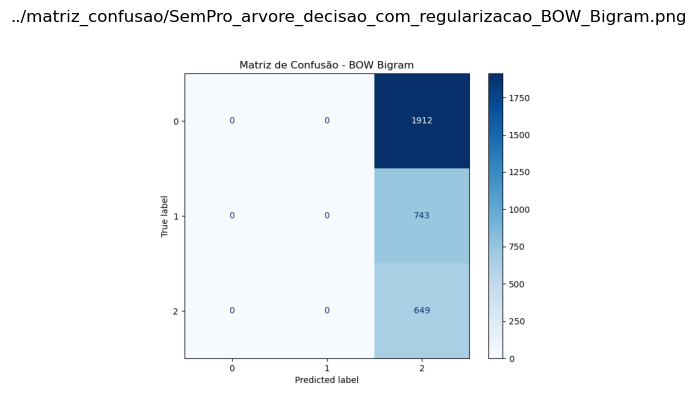

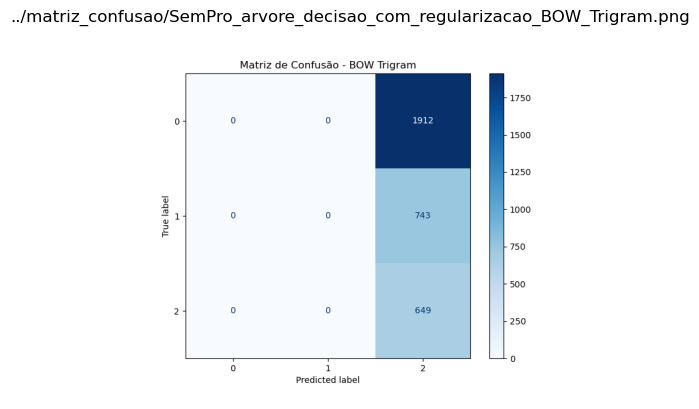

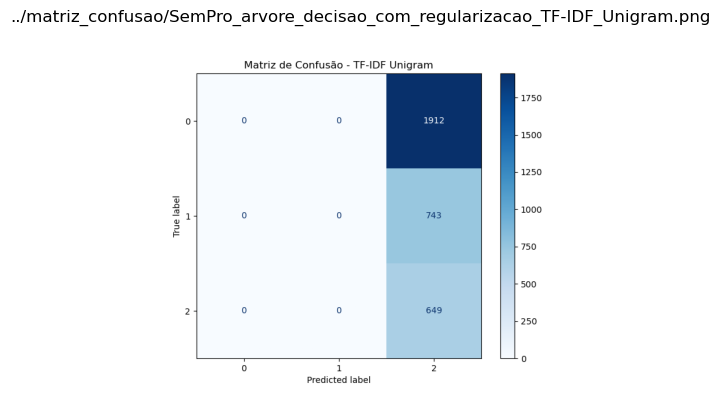

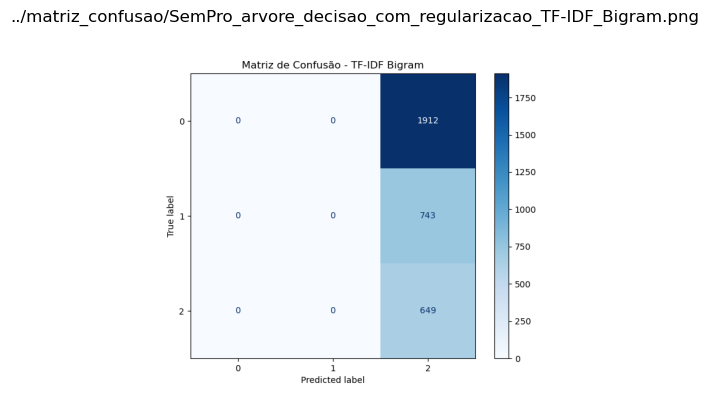

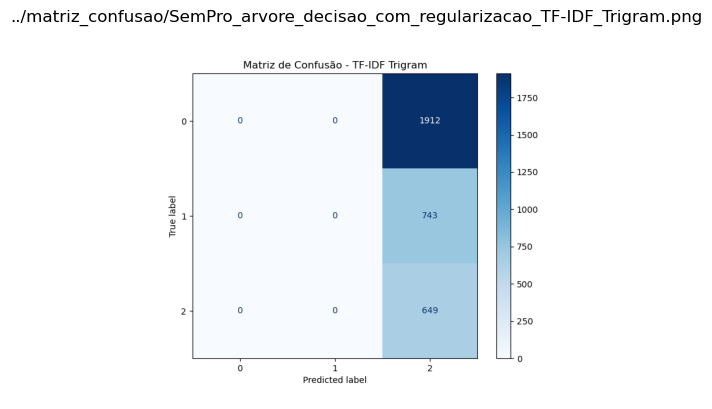

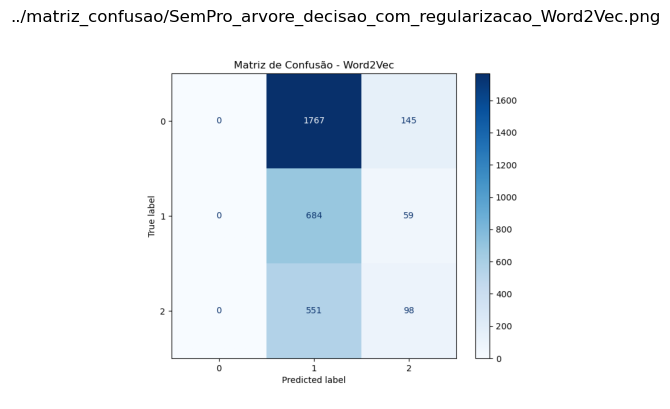

In [31]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_BOW_Unigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_BOW_Bigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_BOW_Trigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_arvore_decisao_com_regularizacao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Gradient Boosting

In [ ]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
models = {
    'Gradiente Boosting': OneVsRestClassifier(GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))

}

scalers = {
    'None': None,
}

In [ ]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'smote'
            )

            # Concatena os resultados
            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_gradient_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_gradient.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

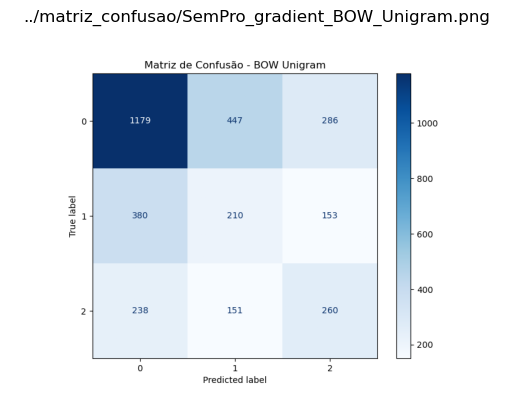

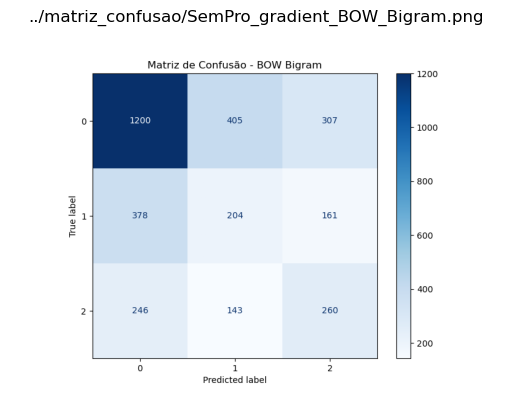

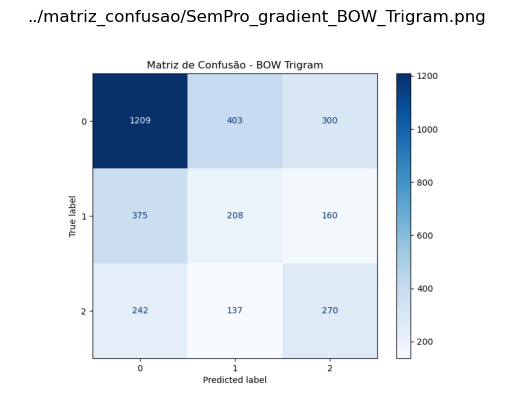

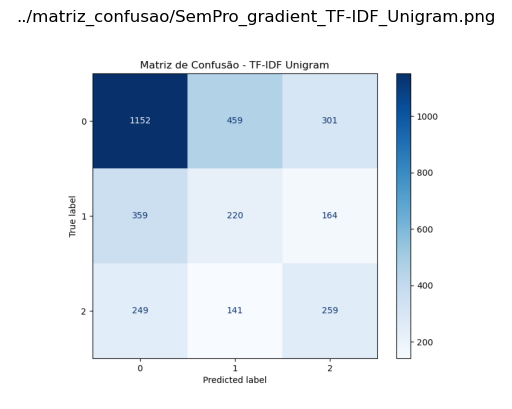

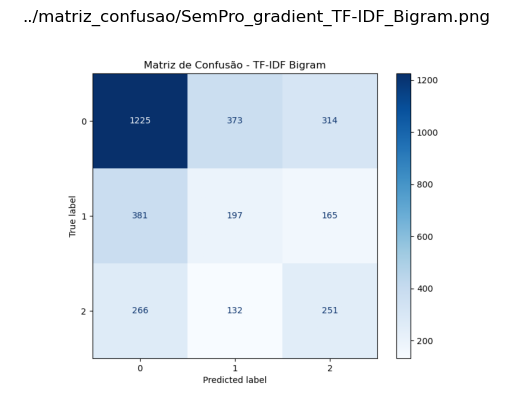

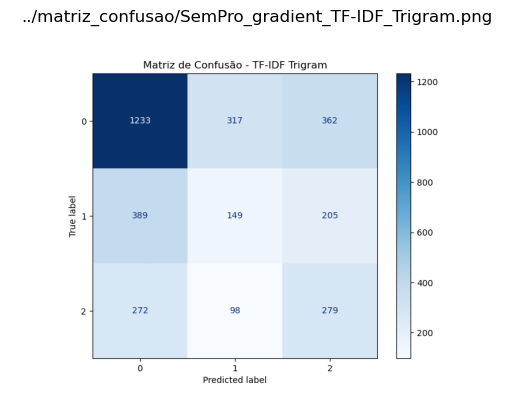

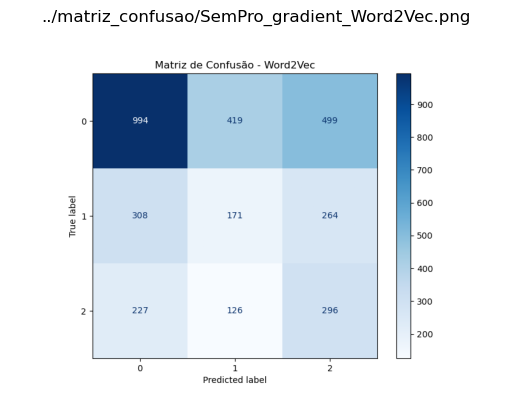

In [ ]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_gradient_BOW_Unigram.png',
    '../matriz_confusao/SemPro_gradient_BOW_Bigram.png',
    '../matriz_confusao/SemPro_gradient_BOW_Trigram.png',
    '../matriz_confusao/SemPro_gradient_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_gradient_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_gradient_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_gradient_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Gradient Boosting com regularização

In [24]:
# Separar as features e o target
X = dfsp['texto_original']
y = dfsp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1), max_features=5000),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2), max_features=7000),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3), max_features=10000),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1), max_features=5000),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2), max_features=7000),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3), max_features=10000),
    'Word2Vec': Word2VecTransformer()
}


In [26]:
models = {
    'Gradiente Boosting ccp_alpha': OneVsRestClassifier(GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        ccp_alpha=1.0
    ))

}

scalers = {
    'None': None,
}

In [27]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'smote'
            )

            # Concatena os resultados
            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/SemPro_gradient_com_regularizacao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/semPro_gradient_com_regularizacao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

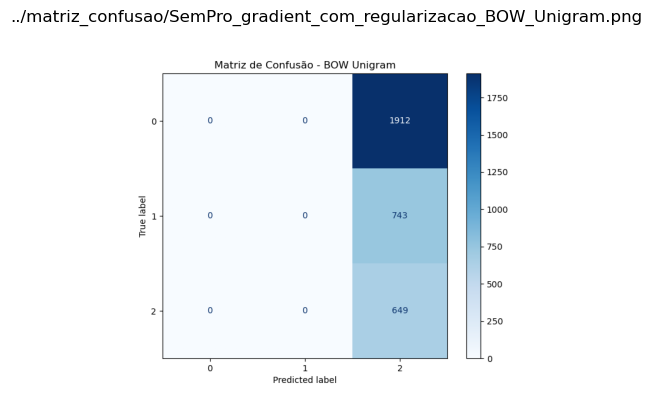

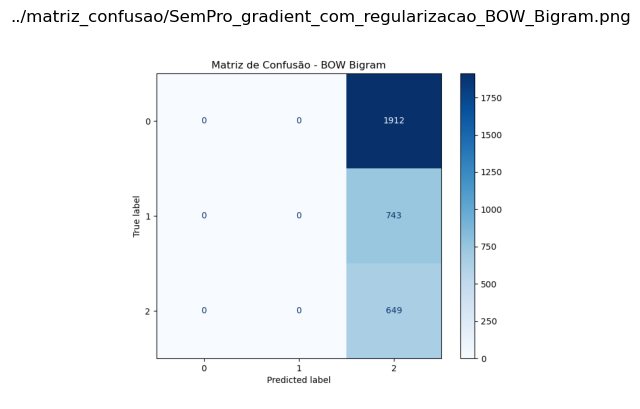

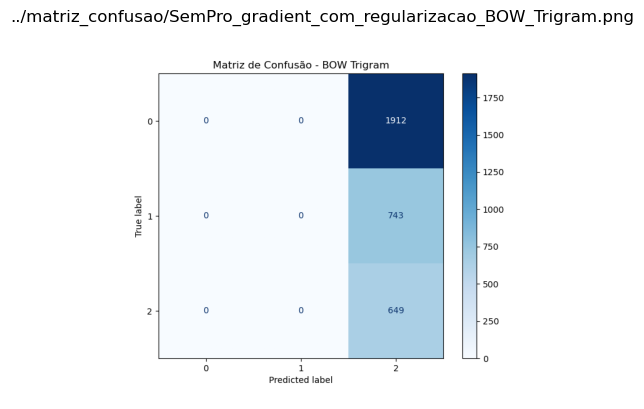

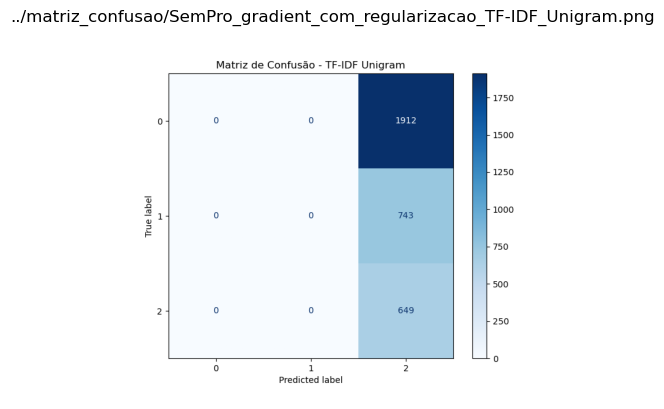

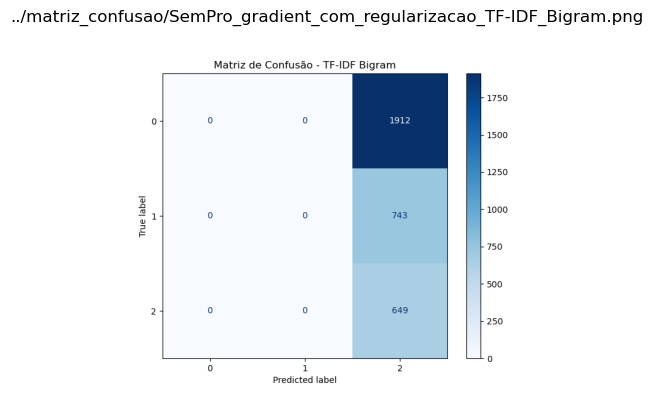

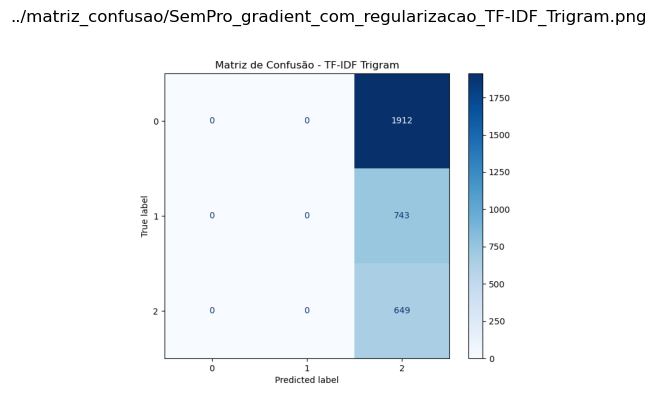

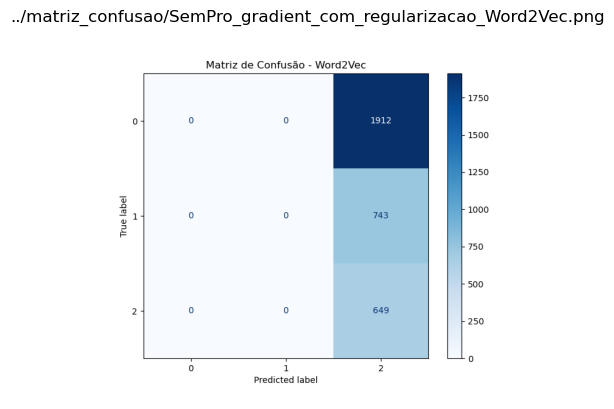

In [28]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/SemPro_gradient_com_regularizacao_BOW_Unigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_BOW_Bigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_BOW_Trigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_TF-IDF_Unigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_TF-IDF_Bigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_TF-IDF_Trigram.png',
    '../matriz_confusao/SemPro_gradient_com_regularizacao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


# Com Pré-processamento

In [8]:
dfcp = telegram.copy()

In [9]:
dfcp = dfcp.replace({3:2, 4:2})
dfcp['classe'].value_counts()

classe
0    9560
1    3716
2    3244
Name: count, dtype: int64

In [8]:
# Contar a quantidade de valores nulos na coluna 'text_processed'
nulos_count = dfcp['text_processed'].isnull().sum()

# Exibir o resultado
print(f"Quantidade de valores nulos na coluna 'text_processed': {nulos_count}")


Quantidade de valores nulos na coluna 'text_processed': 0


## Regressão Logistica

In [10]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
models = {
    'Logistic Regression': OneVsRestClassifier(
        LogisticRegression(
          solver='saga'))


}

scalers = {

     'MaxAbsScaler': MaxAbsScaler()
}

In [ ]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'adasyn'
            )

            # Concatena os resultados
            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_regressao_logistica_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_regressao_logistica.csv', index=False, encoding='utf-8')
print(mean_results)


In [ ]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_regressao_logistica_BOW_Unigram.png',
    '../matriz_confusao/comPro_regressao_logistica_BOW_Bigram.png',
    '../matriz_confusao/comPro_regressao_logistica_BOW_Trigram.png',
    '../matriz_confusao/comPro_regressao_logistica_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_regressao_logistica_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_regressao_logistica_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Regressão Logística com regularização

In [10]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
models = {
    'Logistic Regression l1' : OneVsRestClassifier(LogisticRegression(penalty='l1', solver='saga', C=1.0))
    
}

scalers = {
    'MaxAbsScaler': MaxAbsScaler()
}

In [12]:
results_regressao_logistica = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'smote' ou 'adasyn'
            )

            # Concatena os resultados
            results_regressao_logistica = pd.concat([results_regressao_logistica, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_regressao_logistica_Lasso_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_regressao_logistica.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_regressao_logistica_Lasso.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

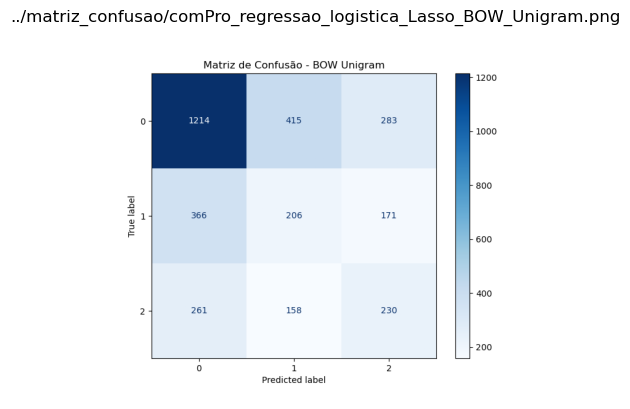

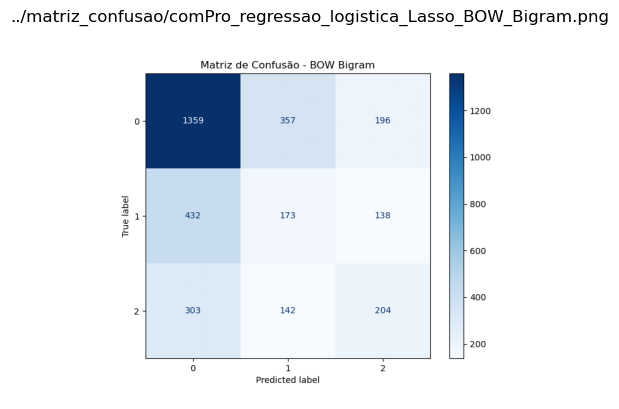

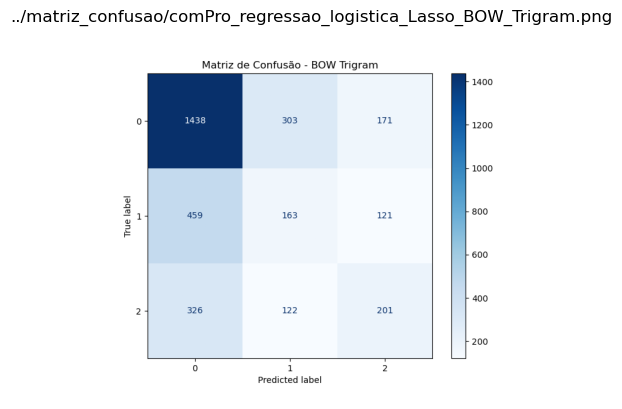

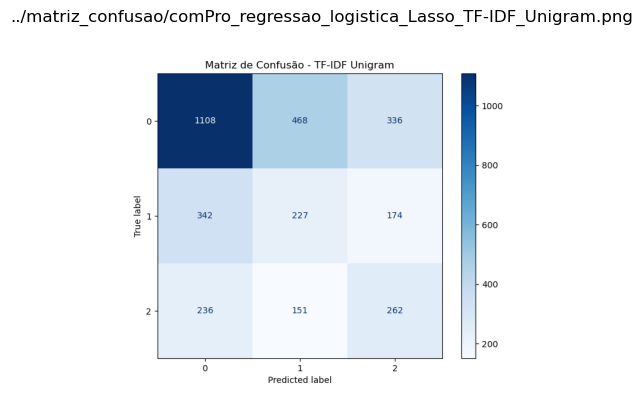

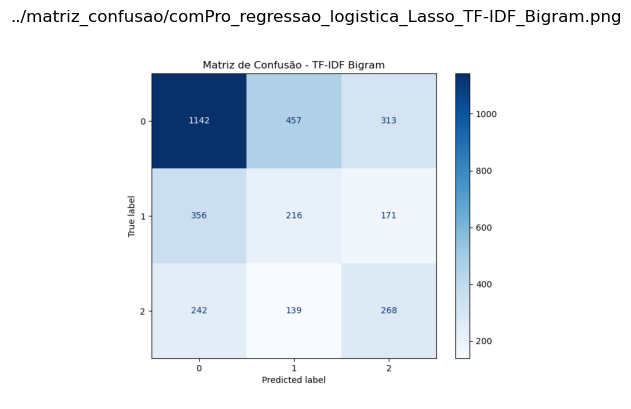

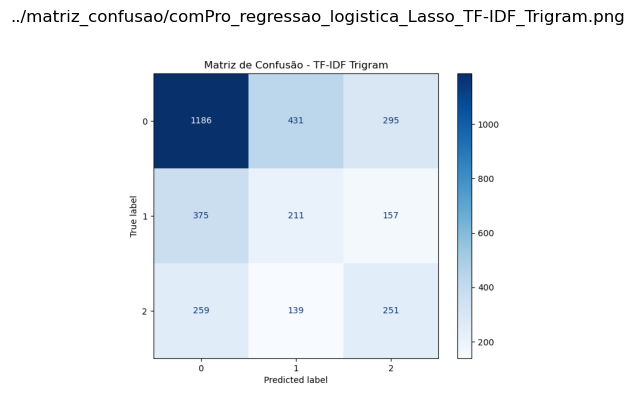

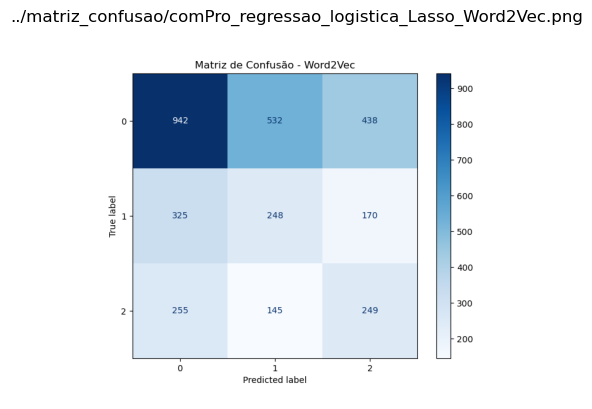

In [15]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_regressao_logistica_Lasso_BOW_Unigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_BOW_Bigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_BOW_Trigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_regressao_logistica_Lasso_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Árvore de decisão

In [16]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:

models = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(
    criterion='entropy',             # 'gini' para medir a impureza dos nós, 'entropy' é uma alternativa
    max_depth=20,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=20,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=20,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001    # Redução mínima de impureza necessária para realizar uma divisão
))
}

scalers = {
    'None': None
}

In [18]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'adasyn'
            )

            # Concatena os resultados
            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_arvore_decisao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_arvore_decisao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

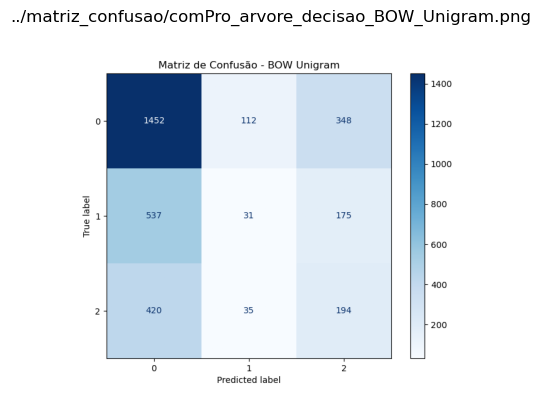

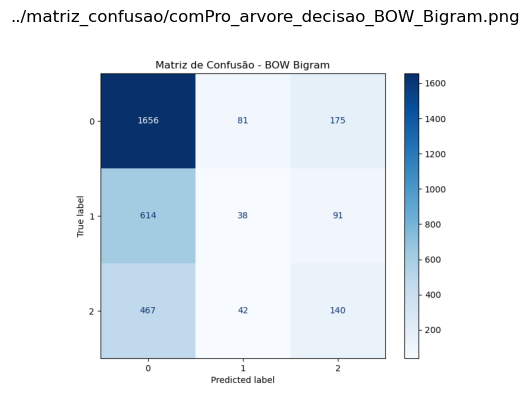

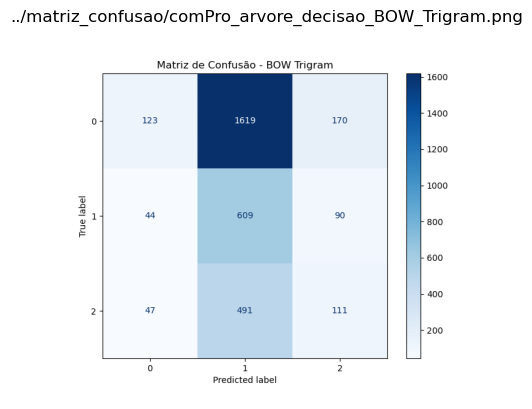

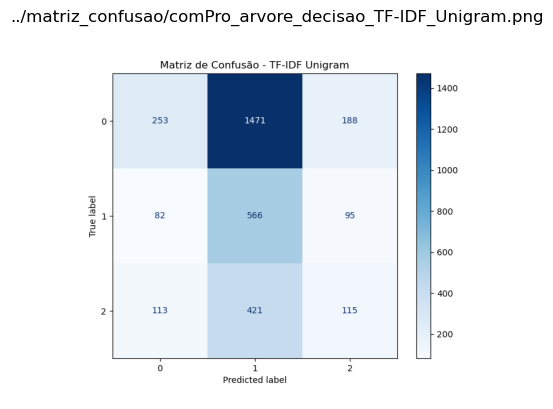

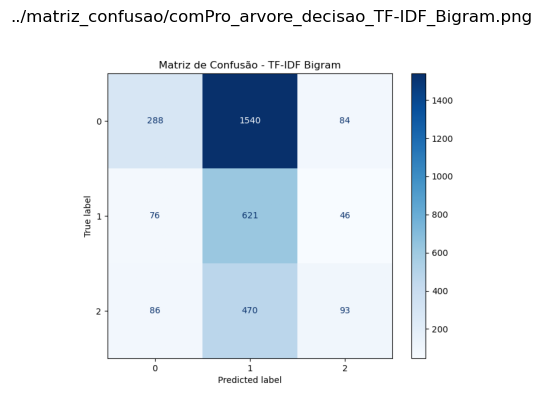

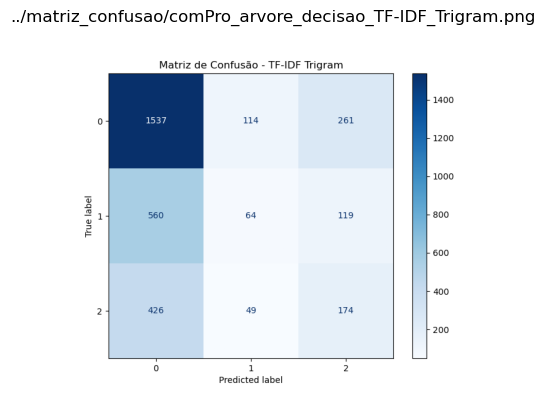

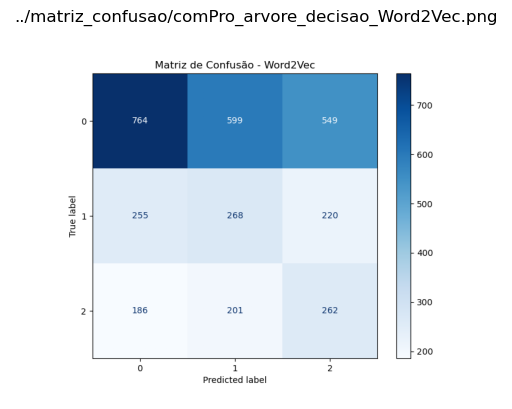

In [19]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_arvore_decisao_BOW_Unigram.png',
    '../matriz_confusao/comPro_arvore_decisao_BOW_Bigram.png',
    '../matriz_confusao/comPro_arvore_decisao_BOW_Trigram.png',
    '../matriz_confusao/comPro_arvore_decisao_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_arvore_decisao_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_arvore_decisao_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_arvore_decisao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Árvore de decisão com regularização

In [20]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:

models = {
    'Decision Tree ccp_alpha': OneVsRestClassifier(DecisionTreeClassifier(
    criterion='entropy',             # 'gini' para medir a impureza dos nós, 'entropy' é uma alternativa
    max_depth=30,                    # Profundidade máxima da árvore para evitar overfitting
    min_samples_split=30,            # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=30,             # Número mínimo de amostras em um nó folha para evitar nós pequenos
    max_features='sqrt',             # Considerar a raiz quadrada do número total de características para divisões
    max_leaf_nodes=100,              # Limitar o número máximo de nós folha para controlar o tamanho da árvore
    min_impurity_decrease=0.0001,    # Redução mínima de impureza necessária para realizar uma divisão
    ccp_alpha=0.01                   # Termo para regularização pois controla a poda de custo-complexidade (valores maiores simplificam a árvore).

))
}

scalers = {
    'None': None
}

In [22]:
results_arvore_decisao = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'smote'
            )

            # Concatena os resultados
            results_arvore_decisao = pd.concat([results_arvore_decisao, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_arvore_decisao_com_regularizacao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_arvore_decisao.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_arvore_decisao_com_regularizacao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

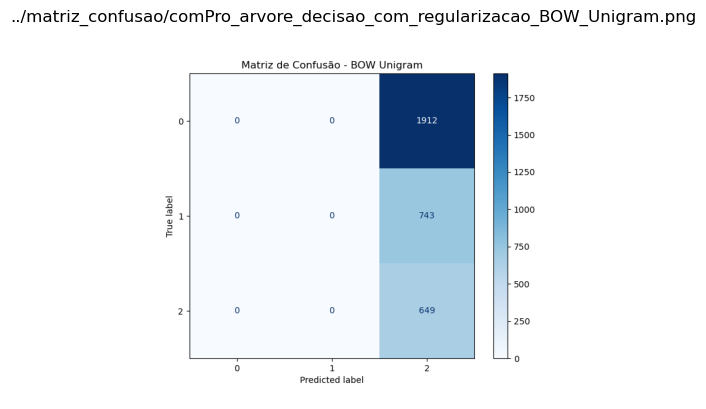

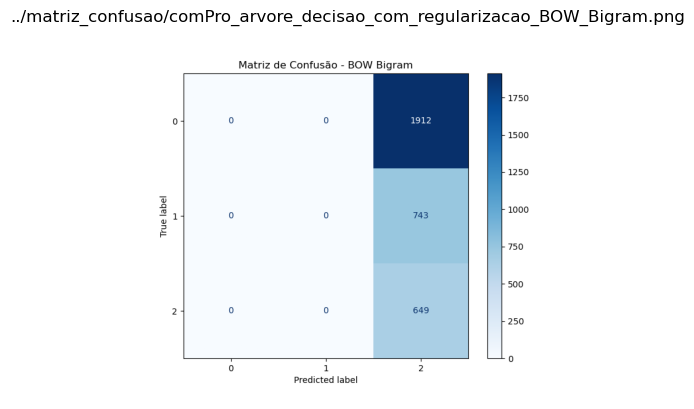

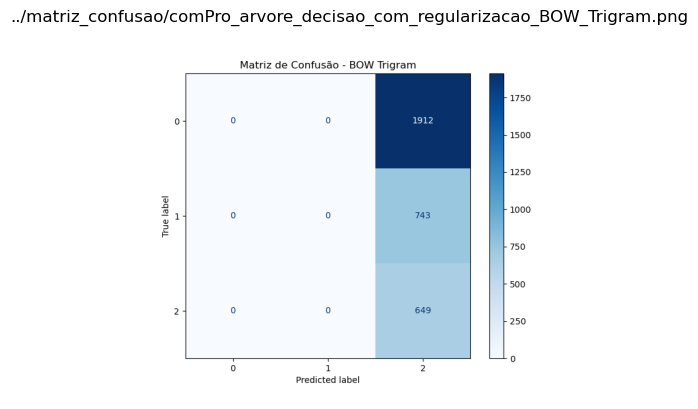

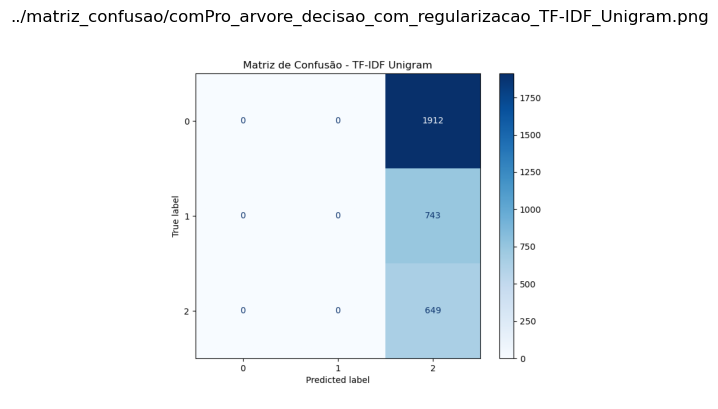

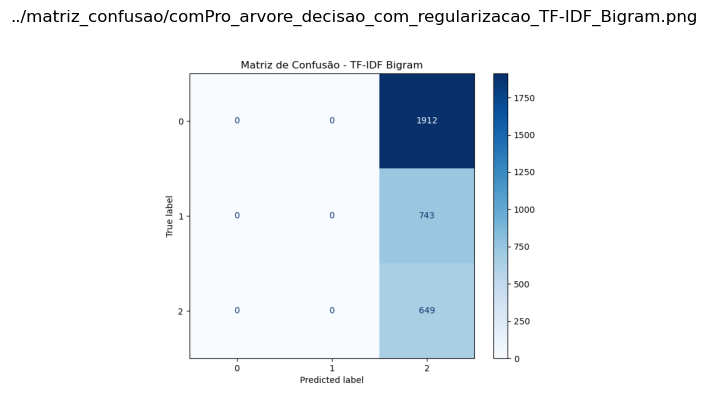

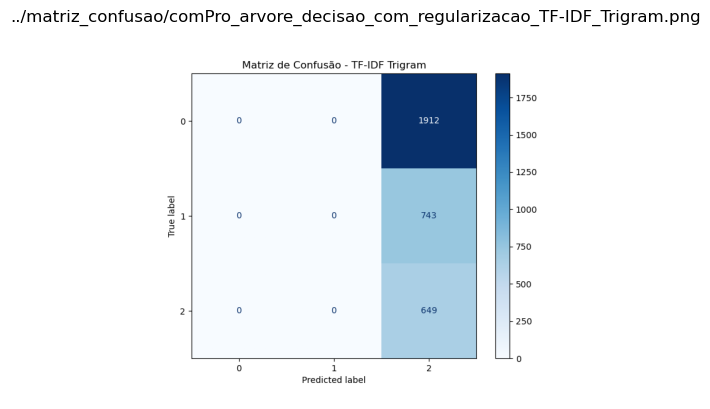

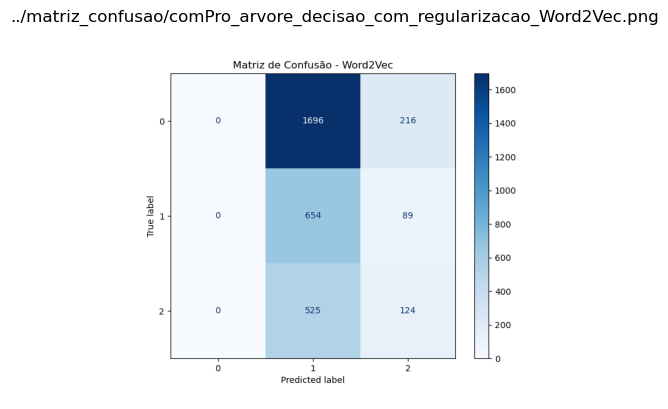

In [23]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_BOW_Unigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_BOW_Bigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_BOW_Trigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_arvore_decisao_com_regularizacao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Gradient Boosting

In [29]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1), max_features=5000),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2), max_features=7000),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3), max_features=10000),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1), max_features=5000),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2), max_features=7000),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3), max_features=10000),
    'Word2Vec': Word2VecTransformer()
}


In [31]:
models = {
    'Gradiente Boosting': GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

}

scalers = {
    'None': None,
}

In [32]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'adasyn'
            )

            # Concatena os resultados
            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_gradient_boosting_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_gradient_boosting.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

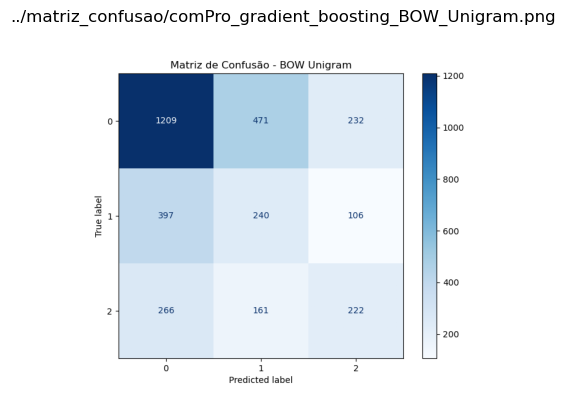

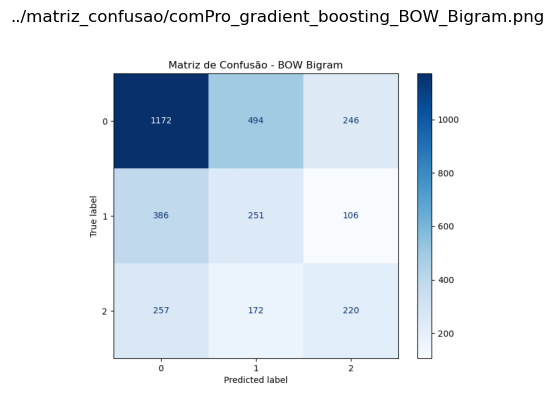

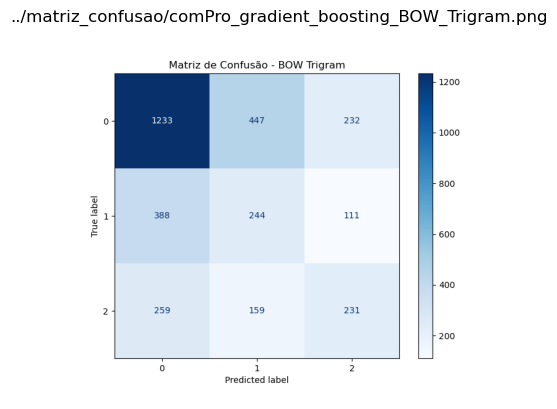

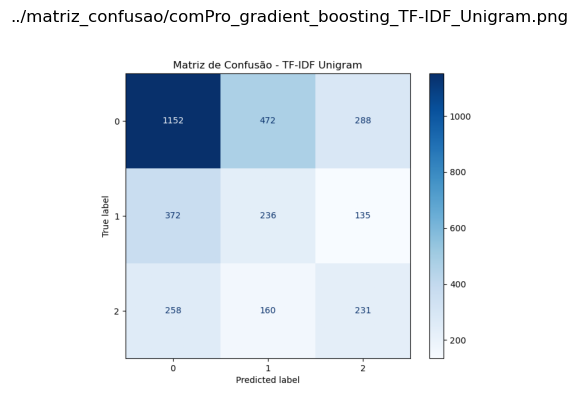

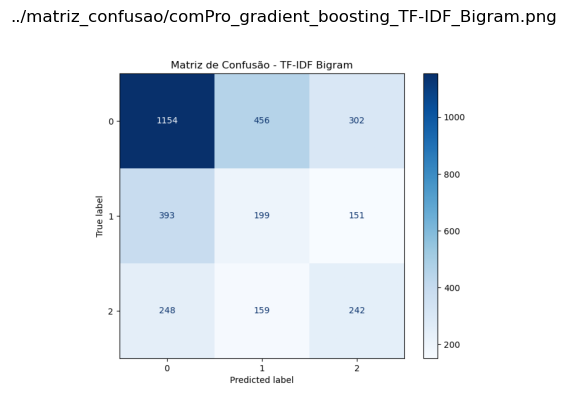

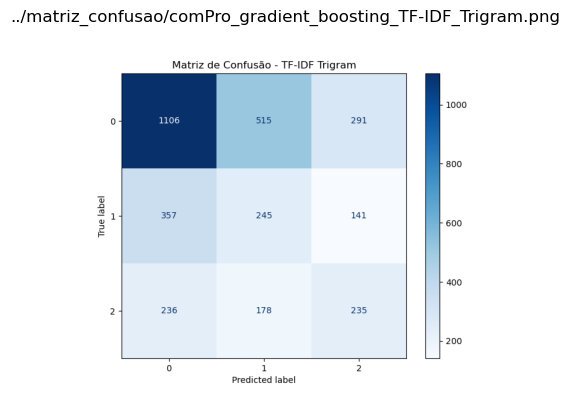

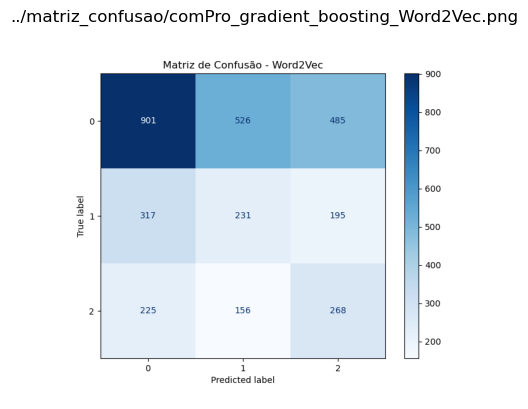

In [34]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_gradient_boosting_BOW_Unigram.png',
    '../matriz_confusao/comPro_gradient_boosting_BOW_Bigram.png',
    '../matriz_confusao/comPro_gradient_boosting_BOW_Trigram.png',
    '../matriz_confusao/comPro_gradient_boosting_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_gradient_boosting_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_gradient_boosting_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_gradient_boosting_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()


## Gradient Boosting Regularização

In [35]:
# Separar as features e o target
X = dfcp['text_processed']
y = dfcp['classe']

# Realizar o Train-Test Split para criar um conjunto de teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
vectorizers = {
    'BOW Unigram': CountVectorizer(ngram_range=(1, 1), max_features=5000),
    'BOW Bigram': CountVectorizer(ngram_range=(1, 2), max_features=7000),
    'BOW Trigram': CountVectorizer(ngram_range=(1, 3), max_features=10000),
    'TF-IDF Unigram': TfidfVectorizer(ngram_range=(1, 1), max_features=5000),
    'TF-IDF Bigram': TfidfVectorizer(ngram_range=(1, 2), max_features=7000),
    'TF-IDF Trigram': TfidfVectorizer(ngram_range=(1, 3), max_features=10000),
    'Word2Vec': Word2VecTransformer()
}


In [37]:
models = {
    'Gradiente Boosting ccp_alpha': GradientBoostingClassifier(
        loss='log_loss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        ccp_alpha=1.0
    )

}

scalers = {
    'None': None,
}


In [38]:
results_gradient_boosting = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            results, y_test_true, y_test_pred = evaluate_model_with_outer_cv(
                X_train_val, y_train_val, X_test, y_test,
                vectorizer, vec_name, model, scaler, oversampler='random'  # ou 'random' ou 'adasyn'
            )

            # Concatena os resultados
            results_gradient_boosting = pd.concat([results_gradient_boosting, results], ignore_index=True)

            # Gerar matriz de confusão
            cm = confusion_matrix(y_test_true, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)

            # Plotar e salvar a imagem da matriz de confusão
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap='Blues')
            ax.set_title(f'Matriz de Confusão - {vec_name}')
            plt.savefig(f'../matriz_confusao/comPro_gradient_boosting_com_regularizacao_{vec_name.replace(" ", "_")}.png')
            plt.close()
mean_results = results_gradient_boosting.groupby(['class', 'Vectorizer', 'Model', 'Scaler']).mean(numeric_only=True).reset_index()

mean_results.to_csv('../resultados/comPro_gradient_boosting_com_regularizacao.csv', index=False, encoding='utf-8')
print(mean_results)



Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe (após oversampling em cada fold):
- Classe 1: 6118 amostras
- Classe 0: 6118 amostras
- Classe 2: 6118 amostras

Resumo final do número de amostras por classe

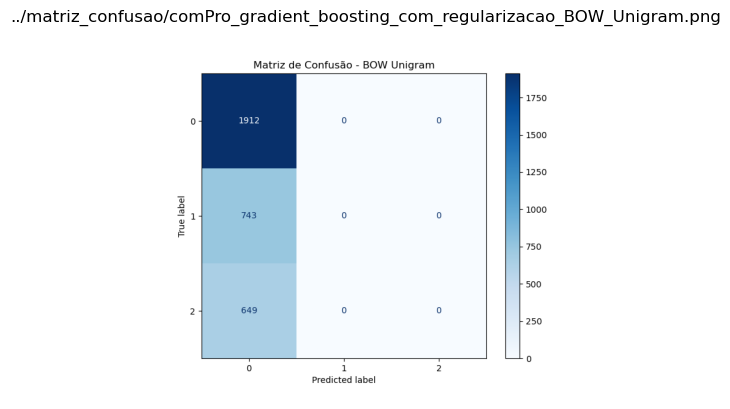

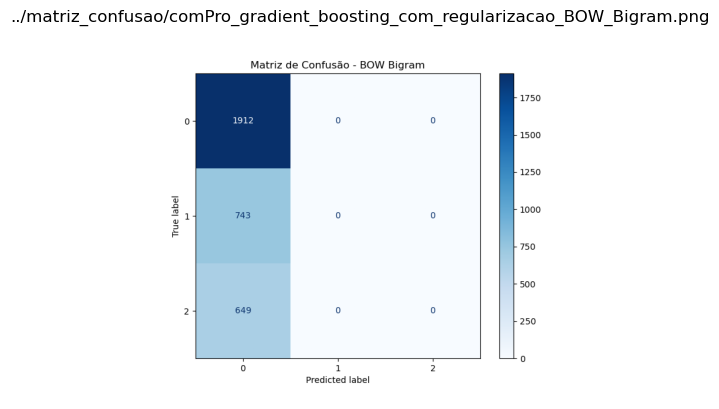

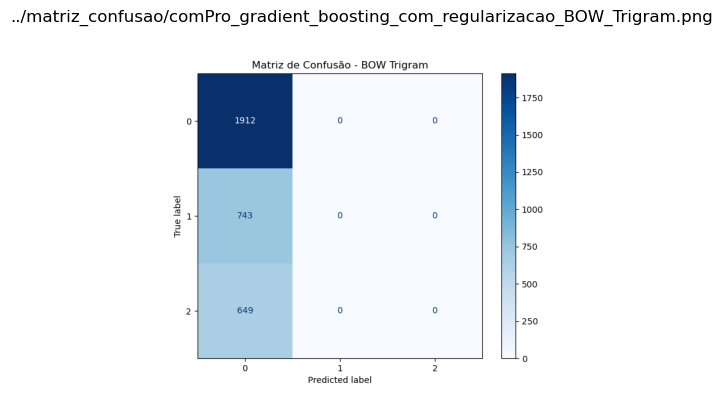

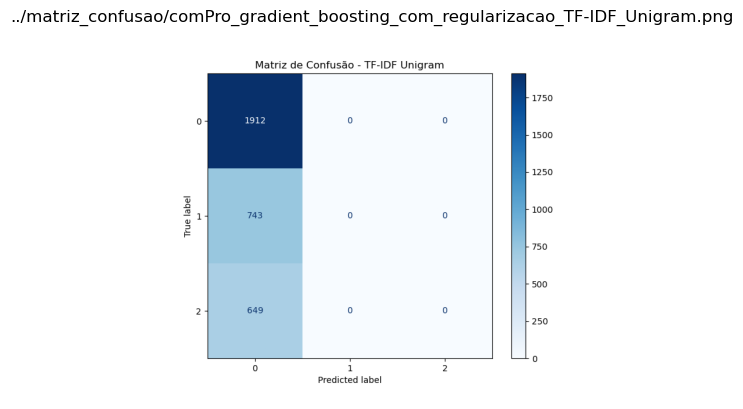

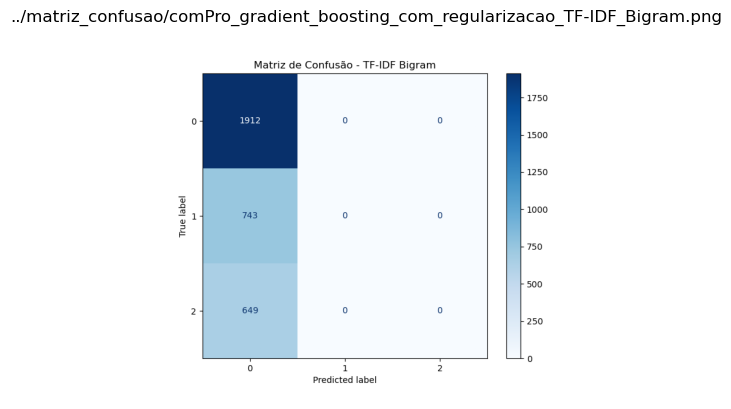

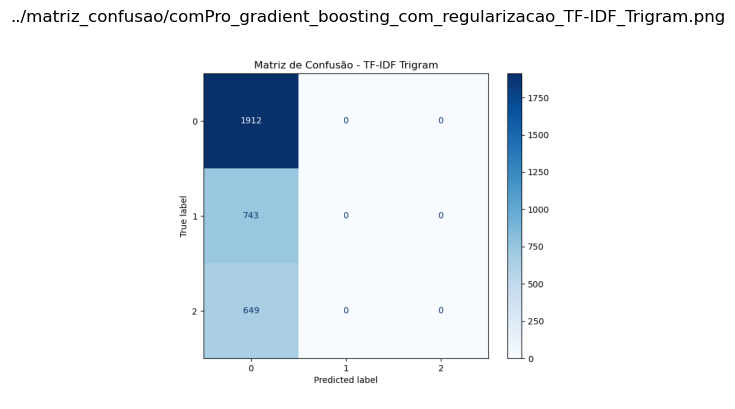

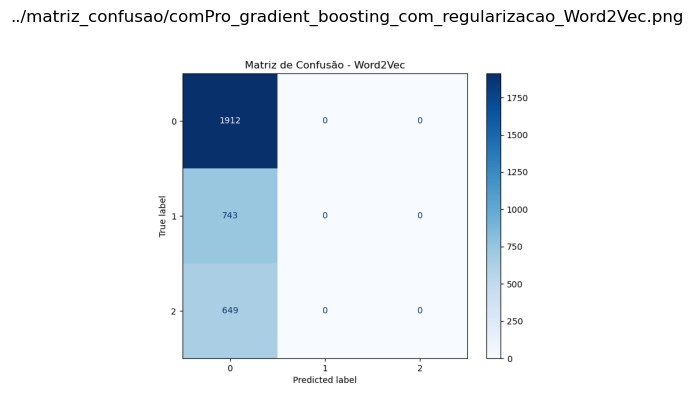

In [39]:

# Lista com os nomes dos arquivos
arquivos = [
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_BOW_Unigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_BOW_Bigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_BOW_Trigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_TF-IDF_Unigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_TF-IDF_Bigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_TF-IDF_Trigram.png',
    '../matriz_confusao/comPro_gradient_boosting_com_regularizacao_Word2Vec.png',
]

# Loop para carregar e exibir cada imagem
for arquivo in arquivos:
    img = mpimg.imread(arquivo)
    plt.imshow(img)
    plt.axis('off')  # Remove os eixos, opcional
    plt.title(arquivo)  # Exibe o nome da imagem como título
    plt.show()
